# Employee Review Analysis
## DATA200 Project by Harshita Nagasubramanian and Vishal Srikanth

### Introduction

Walmart, one of the largest retail corporations globally, is renowned for its vast network of stores and affordable goods. However, discussions around its working conditions have been ongoing. Critics argue that Walmart's labor practices have been a subject of scrutiny, with concerns raised about employee wages, benefits, and workplace environment. Despite these criticisms, Walmart continues to be a dominant force in the retail industry, serving millions of customers worldwide.

Walmart's expansive reach and competitive pricing have solidified its position as a retail giant. However, concerns persist regarding the welfare of its workforce. The following project undertakes an in-depth exploratory analysis of Walmart employee reviews, seeking to understand the prevailing sentiment regarding Walmart's work environment. Central to this investigation are various key factors, including the employment status of Walmart personnel (whether current or former employees), the geographic location of the respective Walmart stores (with varying levels of specificity), numerical ratings assigned by employees on a scale of 1 to 5, detailed written reviews elaborating individual experiences, and timestamps indicating the dates of review postings. By examining these various dimensions, this study aims to uncover valuable insights into the overarching perception and dynamics within Walmart's organizational culture, offering a deeper understanding of the prevailing sentiments expressed by its workforce. 


All the information is sourced from publicly available data. 

### Research Question

How do current and former Walmart employees' reviews, encompassing employment status, store location, numerical ratings, written feedback, and temporal variations, contribute to understanding the overall consensus on Walmart's work environment?

### Additional Inference

Expanding on the exploratory analysis, this project delves into advanced statistical methodologies to glean deeper insights into Walmart's workforce sentiments. Utilizing regression analysis, the average ratings of employees across various states are calculated over time, facilitating the plotting of a linear regression model to predict ratings from 2011 to 2023. This model enhances user-friendliness by allowing input of state abbreviations, enabling customized visualization of the curve and data points for any state of interest. Furthermore, employing bootstrapping techniques enhances the robustness of the analysis by resampling data to assess the stability of statistical estimates and validate results. Additionally, classification methods are leveraged to categorize employee reviews based on sentiment, providing a nuanced understanding of the diverse experiences within the Walmart workforce. Finally, feature engineering techniques are implemented to extract meaningful insights from the available data, enriching the analysis with relevant variables and enhancing predictive accuracy. Together, these advanced methodologies offer a comprehensive understanding of Walmart's organizational culture and employee perceptions, empowering stakeholders with actionable insights for informed decision-making.

### Importing the Data

In [39]:
#%pip install nltk matplotlib wordcloud
#%pip install PIL
#%pip install pandas seaborn numpy scikit-learn
#from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [79]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression

reviews=pd.read_csv('walmart_cleaned.csv')
reviews.head(5)

,index,title,review,rating,status,position,location,date_posted,year,month,day
0,0,great place to work,Indeed Featured reviewThe most useful review s...,4,Former Employee,"CUSTOMER SERVICE SUPERVISOR, OVER-NIGHT","El Paso, TX 79904",23/03/2018,2018,3,23
1,1,No Title,it was good pay but they can definitely start ...,5,Former Employee,Shopper Team Member,"Baton Rouge, LA",11/08/2023,2023,8,11
2,2,Decent,Decent place to work at if you have good manag...,4,Current Employee,Stocking Associate,Colorado,11/08/2023,2023,8,11
3,3,It's retail,"It's a retail job with all the drama, lack of ...",3,Former Employee,Deli Worker,Pennsylvania,11/08/2023,2023,8,11
4,4,"not too strict , laid back job","pretty good job , pretty easy and good pay for...",4,Former Employee,OPD Associate,"San Antonio, TX",11/08/2023,2023,8,11


### EDA (Cleaning & Visualization)
The following is a removal of a redundant column (index) and splitting of the Date column into Year, Month and Day columns

In [80]:
reviews=reviews.drop(columns=['index','date_posted'],axis=1)

The following function is created to categorize the reviews into Pre-Covid, Covid and Post-Covid eras.

In [81]:
def covid_categories(year):
    if year<2020:
        return 'pre-covid era'
    elif 2020<=year<=2021:
        return 'covid era'
    elif year>2021:
        return 'post-covid era'

reviews['covid category']=reviews['year'].apply(covid_categories)

In [45]:
# Group by the required columns and count the occurrences
reviews_count = reviews.groupby(['rating', 'status', 'covid category']).size().reset_index(name='count')

The following code generates a stacked bar chart showing the distribution of employee ratings across different Covid eras and employment statuses. The chart has bars grouped by each unique rating value (1 through 5) on the x-axis. Each group of bars represents a different Covid era, distinguished by color, and within each era, there are stacked bars for current and former employees, also distinguished by color. The height of each segment of the stacked bars corresponds to the count of reviews with that particular rating, employment status, and Covid era. The legend provides clarification on the colors used for each Covid category and employment status combination.

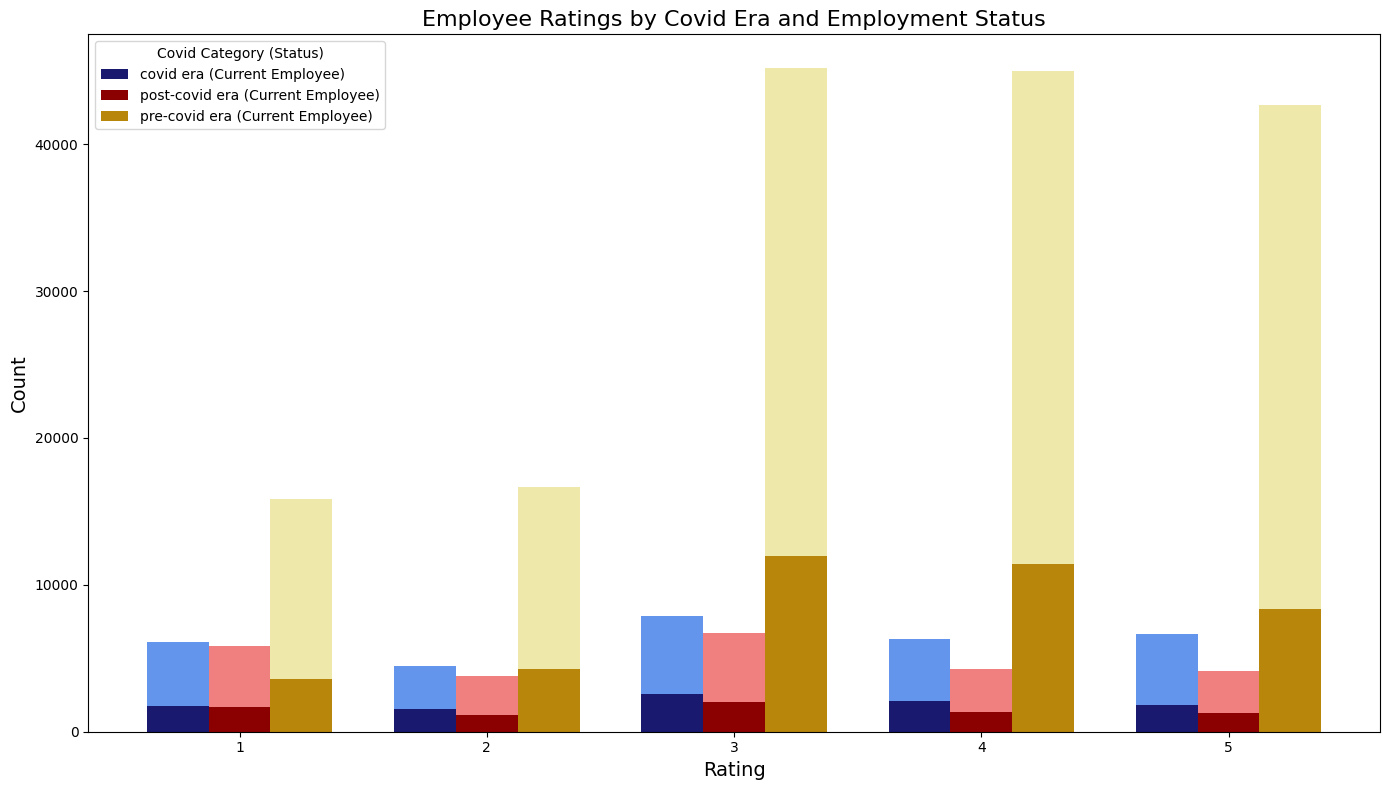

In [46]:
# Define the new colors for each Covid category and status
covid_status_colors = {
    'pre-covid era': {'Current Employee': 'darkgoldenrod', 'Former Employee': 'palegoldenrod'},
    'covid era': {'Current Employee': 'midnightblue', 'Former Employee': 'cornflowerblue'},
    'post-covid era': {'Current Employee': 'darkred', 'Former Employee': 'lightcoral'}
}

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the bars
width = 0.25  # the width of the bars
ind = np.arange(len(reviews_count['rating'].unique()))  # the x locations for the groups

# Group by 'covid_category' this time
for i, (covid_category, sub_df) in enumerate(reviews_count.groupby('covid category')):
    # Stack by 'status'
    bottom = np.zeros(len(reviews['rating'].unique()))  # reset bottom for each covid category
    for status in ['Current Employee', 'Former Employee']:
        values = sub_df[sub_df['status'] == status]['count'].values
        ax.bar(ind + i * width, values, width, bottom=bottom, color=covid_status_colors[covid_category][status], label=f"{covid_category} ({status})" if bottom.sum() == 0 else "")
        bottom += values

# Set the chart title and labels
ax.set_title('Employee Ratings by Covid Era and Employment Status', fontsize=16)
ax.set_xlabel('Rating', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Set the x-ticks and x-tick labels
ax.set_xticks(ind + width)
ax.set_xticklabels(('1', '2', '3', '4', '5'))

# Add a legend
ax.legend(title='Covid Category (Status)')

# Show the plot
plt.tight_layout()
plt.show()

The following is done to make the RegEx analysis easier, all the state names are normalized to only show state abbreviations. In the dataset, some of the locations have state abbreviations and state names, and are inconsistent with their capitalizations. Additionally, reviews with no state specified are removed. 

In [82]:
states = [
    ['Alabama', 'AL'], ['Alaska', 'AK'], ['Arizona', 'AZ'], ['Arkansas', 'AR'], ['California', 'CA'],
    ['Colorado', 'CO'], ['Connecticut', 'CT'], ['Delaware', 'DE'], ['Florida', 'FL'], ['Georgia', 'GA'],
    ['Hawaii', 'HI'], ['Idaho', 'ID'], ['Illinois', 'IL'], ['Indiana', 'IN'], ['Iowa', 'IA'],
    ['Kansas', 'KS'], ['Kentucky', 'KY'], ['Louisiana', 'LA'], ['Maine', 'ME'], ['Maryland', 'MD'],
    ['Massachusetts', 'MA'], ['Michigan', 'MI'], ['Minnesota', 'MN'], ['Mississippi', 'MS'], ['Missouri', 'MO'],
    ['Montana', 'MT'], ['Nebraska', 'NE'], ['Nevada', 'NV'], ['New Hampshire', 'NH'], ['New Jersey', 'NJ'],
    ['New Mexico', 'NM'], ['New York', 'NY'], ['North Carolina', 'NC'], ['North Dakota', 'ND'], ['Ohio', 'OH'],
    ['Oklahoma', 'OK'], ['Oregon', 'OR'], ['Pennsylvania', 'PA'], ['Rhode Island', 'RI'], ['South Carolina', 'SC'],
    ['South Dakota', 'SD'], ['Tennessee', 'TN'], ['Texas', 'TX'], ['Utah', 'UT'], ['Vermont', 'VT'],
    ['Virginia', 'VA'], ['Washington', 'WA'], ['West Virginia', 'WV'], ['Wisconsin', 'WI'], ['Wyoming', 'WY']
]

def state_column(location):
    for state in states:
        if state[0].lower() in location.lower() or state[1].lower() in location.lower():
            return state[1]
    return 'none'

reviews['state']=reviews['location'].apply(state_column)
reviews = reviews[reviews['state'] != 'none']
reviews=reviews.drop(columns=['location'], axis=1)
reviews.reset_index(drop=True, inplace=True)

Next, we take the average rating per state.

In [49]:
average_rating_by_state = reviews.groupby('state')['rating'].mean().reset_index()
# Rename the columns to match your desired new dataset
average_rating_by_state.columns = ['state', 'average rating']

In [50]:
#Introducing a file with geographic location to create a heatmap 
#%pip install geopandas
import geopandas as gpd
US = gpd.read_file("gz_2010_us_040_00_5m.json")
US.head(5)

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


The following code snippet performs a data cleaning operation on a GeoDataFrame containing states. It defines a function, remove_states, to systematically filter out specific states identified in a predefined list named states_to_remove. The function iterates through each row of the GeoDataFrame, excluding rows corresponding to states listed in states_to_remove. Once executed, the filtered GeoDataFrame is printed, presenting a refined dataset ready for subsequent analysis. This method ensures data integrity by removing irrelevant states and streamlining the dataset for more focused geospatial analyses or visualizations.

In [51]:
# Define the list of states to be removed
states_to_remove = ['District of Columbia', 'Puerto Rico', 'Alaska', 'Hawaii']  # Add other states as needed

# Function to remove states from the GeoDataFrame
def remove_states(row):
    if row['NAME'] in states_to_remove:
        return None
    else:
        return row

# Apply the function to filter out specified states
US_filtered = US.apply(remove_states, axis=1).dropna()
US_filtered['STATE ABB']=US_filtered['NAME'].apply(state_column)
US_filtered.reset_index(drop=True, inplace=True)

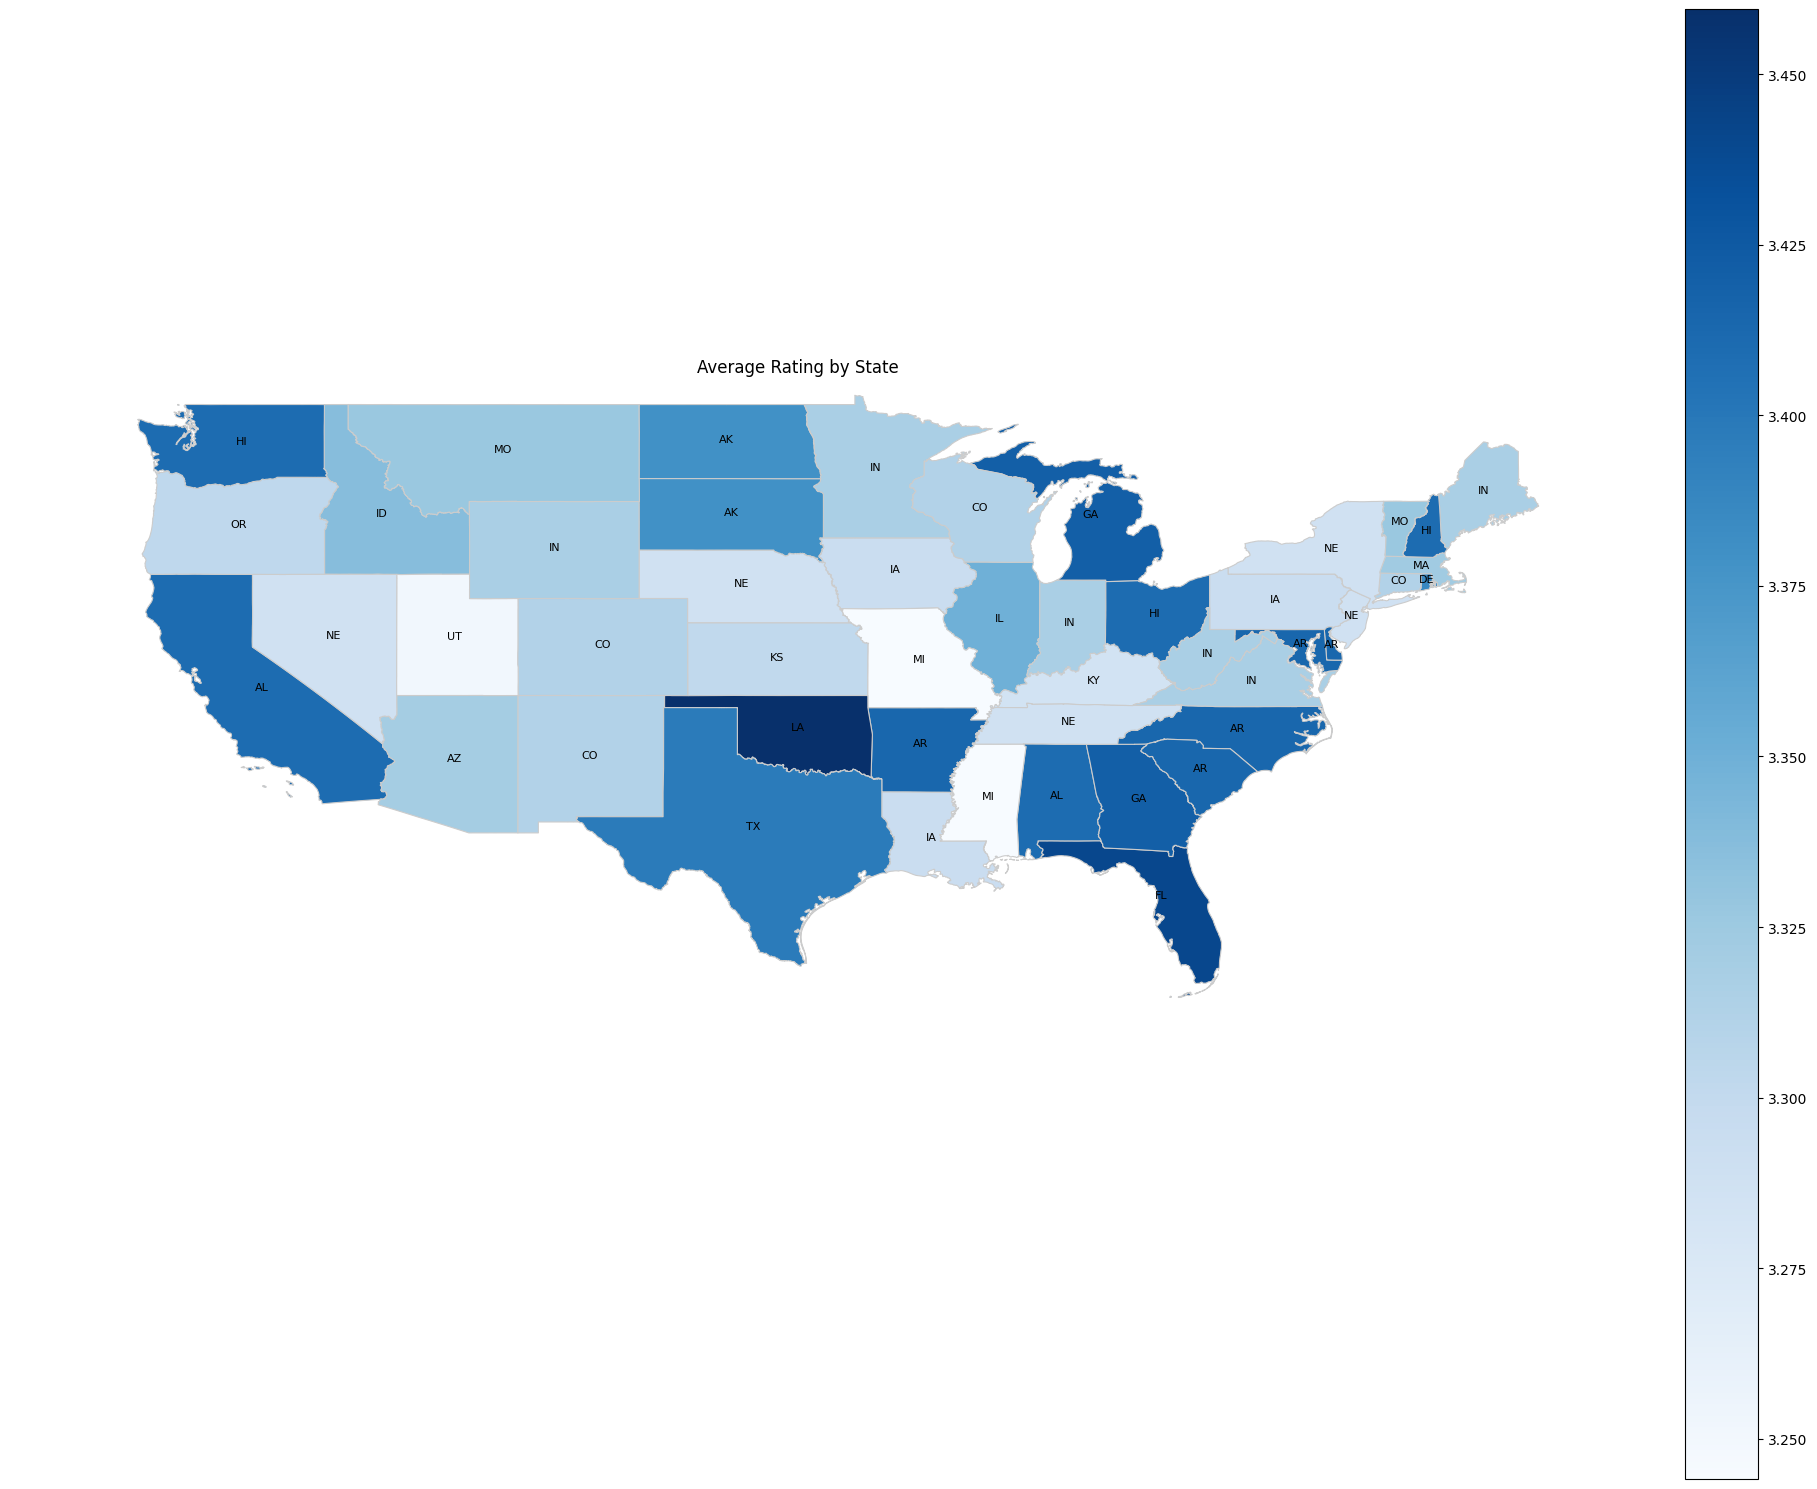

In [52]:
# Merge the shapefile data with the average rating data
merged_data = US_filtered.merge(average_rating_by_state, how='left', left_on='STATE ABB', right_on='state')

# Increase the figure size here
fig, ax = plt.subplots(1, figsize=(20, 15))  # You can increase these numbers

# Plot the choropleth map with a less extreme colormap
merged_data.plot(column='average rating', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set plot title
plt.title('Average Rating by State')

for idx, row in US_filtered.iterrows():
    # Get the centroid of the polygon
    centroid = row['geometry'].centroid
    # Add the state name as text at the centroid
    ax.text(centroid.x, centroid.y, row['STATE ABB'], fontsize=8, ha='center', color='black')

# Remove the axis
ax.axis('off')

# Optional: Adjust the aspect ratio
ax.set_aspect('equal')

# Optional: Adjust the limits if the map is not filling the figure
plt.xlim(-130, -65)  # Adjust these values as needed to fit your desired area
plt.ylim(20, 50)     # Adjust these values as needed to fit your desired area

# Optional: Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


This visualization presents a comprehensive overview of average ratings extracted from Walmart employee reviews across various states in the United States. By integrating shapefile data with average rating metrics, each state is assigned a color gradient reflective of its collective employee sentiment. Departing from the stark color contrasts of previous iterations, we've opted for a more subdued palette, leveraging the 'Blues' colormap for a refined visual representation. This approach fosters a smoother transition between neighboring regions, facilitating a nuanced interpretation of state-wise ratings. Additionally, the inclusion of state abbreviations strategically positioned within each polygon enhances geographic clarity and aids in state identification. Through this refined visualization, stakeholders gain valuable insights into the nuanced regional dynamics of employee experiences within Walmart, fostering informed decision-making and deeper understanding of workforce sentiment.

### Linear Regression

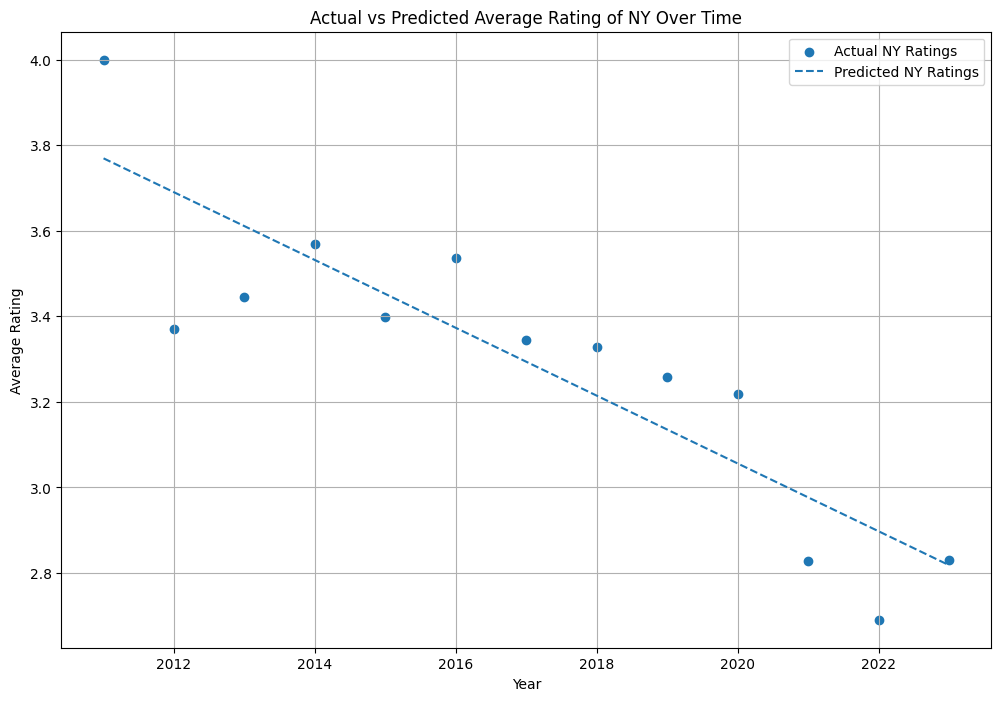

In [53]:
# Calculate average rating for each state and year combination
average_rating_by_state_year = reviews.groupby(['state', 'year'])['rating'].mean().reset_index()

# Plot actual and predicted average rating against year for each state
plt.figure(figsize=(12, 8))

# Input state
state=input('Enter state: ')
# Filter data for the current state
data = average_rating_by_state_year[average_rating_by_state_year['state'] == state]
    
# Prepare the data for linear regression
X = data[['year']]
y = data['rating']
    
# Initialize the linear regression model
model = LinearRegression()
    
# Fit the model
model.fit(X, y)
    
# Make predictions
y_pred = model.predict(X)
    
# Plot actual ratings
plt.scatter(data['year'], data['rating'], label=f'Actual {state} Ratings')
    
# Plot predicted ratings
plt.plot(data['year'], y_pred, label=f'Predicted {state} Ratings', linestyle='--')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Average Rating')
titl='Actual vs Predicted Average Rating of '+state+' Over Time'
plt.title(titl)
plt.legend()
plt.grid(True)
plt.show()

This visualization showcases a comparison between actual and predicted average ratings over time for a specific state within the United States, derived from Walmart employee reviews. The process begins by calculating the average rating for each state-year combination, thereby providing a granular understanding of temporal trends in employee sentiment. Upon user input of a desired state, the corresponding data is filtered, and linear regression is applied to model the relationship between the year and average rating. The resulting predictions are then juxtaposed against the actual ratings, offering insights into the model's performance in capturing temporal variations. The scatter plot depicts the actual ratings over successive years, while the dashed line represents the model's predicted ratings. Through this visualization, stakeholders gain valuable insights into the dynamic evolution of employee perceptions within Walmart across different states over time, facilitating informed decision-making and strategic planning.

### Boostrapping 


The inference task for the described bootstrapping analysis involves understanding the variability and uncertainty associated with certain parameters or model predictions based on a given dataset.

In the provided code, we perform two main inference tasks using bootstrapping:

Parameter Estimation: We estimate the mean rating of the dataset using bootstrapping. By repeatedly resampling the dataset with replacement and calculating the mean rating for each resample, we obtain a distribution of mean ratings. From this distribution, we can calculate confidence intervals to understand the range of plausible values for the mean rating. This allows us to infer the uncertainty associated with our estimate of the mean rating.

Model Uncertainty: We assess the uncertainty of a linear regression model's predictions using bootstrapping. By resampling the dataset with replacement, fitting a linear regression model to each resample, and calculating the Mean Squared Error (MSE) for each model, we obtain a distribution of MSE scores. From this distribution, we can calculate confidence intervals to understand the variability in model performance. This allows us to infer the uncertainty associated with the model's predictions.

In summary, the inference task is to quantify and understand the uncertainty and variability associated with certain parameters (mean rating) and model predictions (MSE) based on the given dataset through bootstrapping.

In [54]:

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Function to perform bootstrapping and estimate parameter
def bootstrap_parameter_estimation(data, parameter='rating', n_bootstraps=1000):
    parameters = []
    for _ in range(n_bootstraps):
        # Resample data with replacement
        resample = data.sample(n=len(data), replace=True)
        # Calculate parameter of interest (mean rating in this case)
        parameter_value = resample[parameter].mean()
        parameters.append(parameter_value)
    return parameters

# Perform bootstrapping for parameter estimation
bootstrapped_ratings = bootstrap_parameter_estimation(reviews)

# Calculate confidence interval
confidence_interval = np.percentile(bootstrapped_ratings, [2.5, 97.5])
print("95% Confidence Interval for Mean Rating:", confidence_interval)

# Function to perform bootstrapping for model uncertainty
def bootstrap_model_uncertainty(data, n_bootstraps=100):
    mse_scores = []
    for _ in range(n_bootstraps):
        # Resample data with replacement
        resample = data.sample(n=len(data), replace=True)
        # Fit a linear regression model
        X_train = resample[['year']]
        y_train = resample['rating']
        X_test = data[['year']]  # You may want to use a separate test set
        y_test = data['rating']   # You may want to use a separate test set
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions
        y_pred = model.predict(X_test)
        # Calculate Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    return mse_scores

# Perform bootstrapping for model uncertainty
bootstrapped_mse = bootstrap_model_uncertainty(reviews)

# Calculate confidence interval
confidence_interval_mse = np.percentile(bootstrapped_mse, [2.5, 97.5])
print("95% Confidence Interval for Model Uncertainty (MSE):", confidence_interval_mse)


95% Confidence Interval for Mean Rating: [3.3644692  3.37584348]
95% Confidence Interval for Model Uncertainty (MSE): [1.64857527 1.64863008]


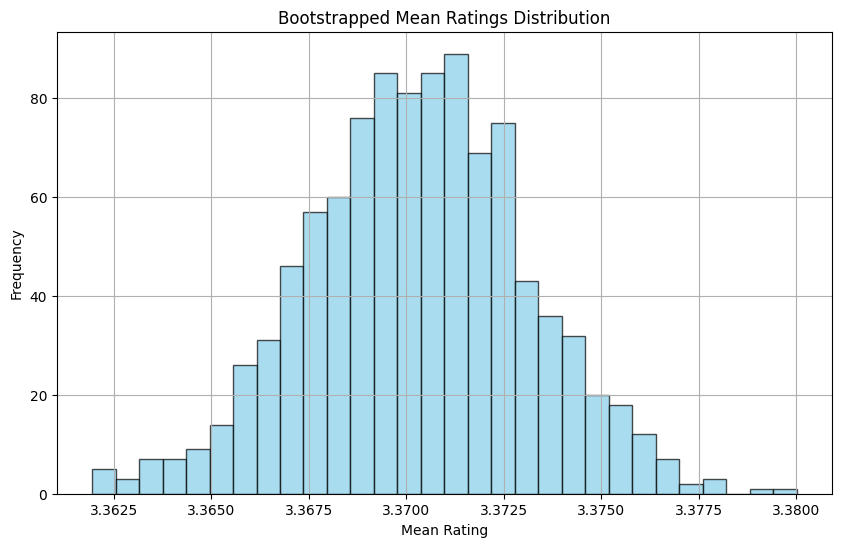

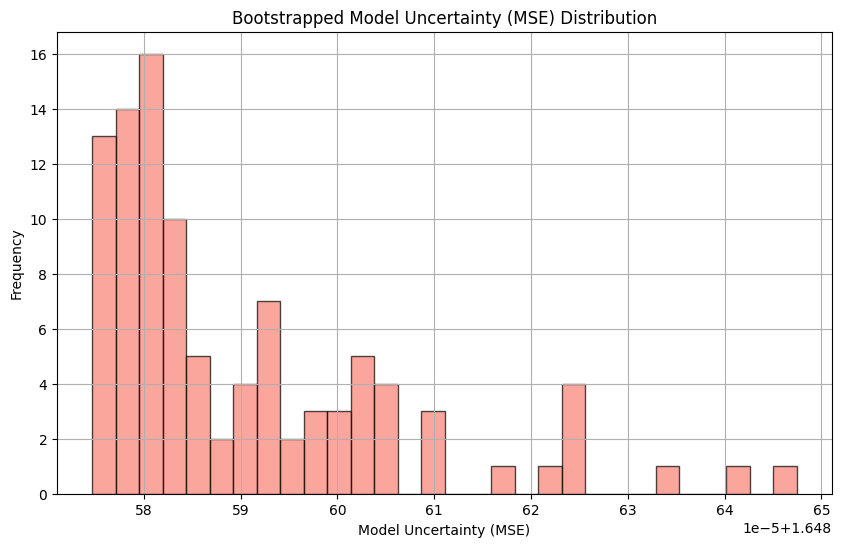

In [55]:
# Plot bootstrapped mean ratings
plt.figure(figsize=(10, 6))
plt.hist(bootstrapped_ratings, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')
plt.title('Bootstrapped Mean Ratings Distribution')
plt.grid(True)
plt.show()

# Plot bootstrapped model uncertainties (MSE)
plt.figure(figsize=(10, 6))
plt.hist(bootstrapped_mse, bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Model Uncertainty (MSE)')
plt.ylabel('Frequency')
plt.title('Bootstrapped Model Uncertainty (MSE) Distribution')
plt.grid(True)
plt.show()

### Cross-Validation

In [56]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Assuming 'reviews' dataset is defined somewhere in your code

# Prepare features and target variable
X = reviews[['year']]  # Feature
y = reviews['rating']  # Target variable

# Initialize models
linear_regression_model = LinearRegression()
random_forest_model = RandomForestRegressor()

# Hyperparameter tuning using cross-validation
# Linear Regression
linear_regression_scores = cross_val_score(linear_regression_model, X, y, cv=5, scoring='neg_mean_squared_error')
linear_regression_rmse = np.sqrt(-linear_regression_scores.mean())

# Random Forest
random_forest_scores = cross_val_score(random_forest_model, X, y, cv=5, scoring='neg_mean_squared_error')
random_forest_rmse = np.sqrt(-random_forest_scores.mean())

# Model comparison
print("Linear Regression RMSE:", linear_regression_rmse)
print("Random Forest RMSE:", random_forest_rmse)


Linear Regression RMSE: 1.3091010240723202
Random Forest RMSE: 1.3074943370092127


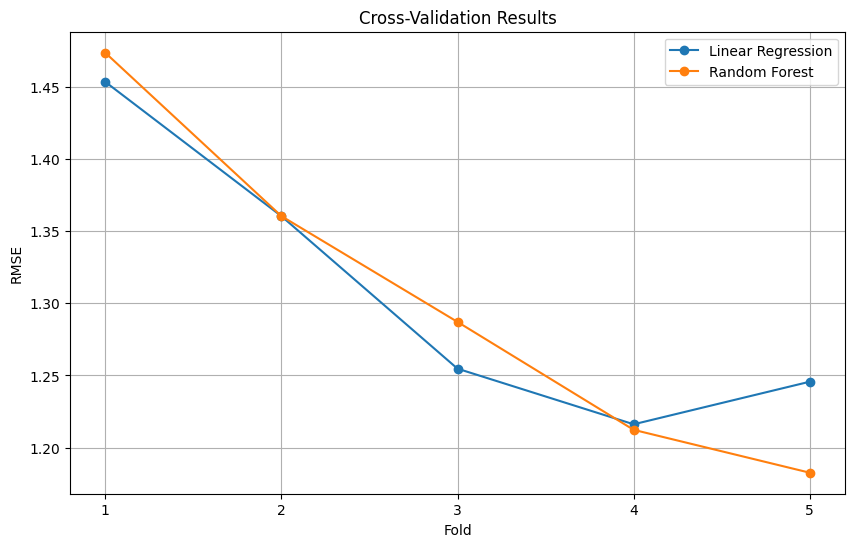

In [57]:
import matplotlib.pyplot as plt

# Define the number of folds for cross-validation
n_folds = 5

# Plotting
plt.figure(figsize=(10, 6))

# Plot RMSE for each fold and model (Linear Regression and Random Forest)
plt.plot(range(1, n_folds + 1), np.sqrt(-linear_regression_scores), marker='o', label='Linear Regression')
plt.plot(range(1, n_folds + 1), np.sqrt(-random_forest_scores), marker='o', label='Random Forest')

# Labels and title
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation Results')
plt.xticks(range(1, n_folds + 1))
plt.legend()
plt.grid(True)
plt.show()


The code above takes us through a methodical evaluation of two predictive models, Linear Regression and Random Forest, using the dataset 'reviews.' The essence of the exercise is to predict 'rating' based on the 'year' feature within the dataset.

What stands out in this code is the use of cross-validation, a robust technique in machine learning to assess how the outcomes of a statistical analysis will generalize to an independent dataset. Specifically, a 5-fold cross-validation is employed here, which means the data is split into five parts, the model is trained on four parts and validated on the fifth, and this process is repeated five times.

The RMSE—Root Mean Squared Error—is the chosen gauge for model accuracy. It essentially tells us how far off our predictions are, on average, from the actual outcomes. In predictive modeling, we aim for lower RMSE values as they indicate higher accuracy.

The code outputs the average RMSE for both models over the folds, but it’s in the visualization where the story unfolds. The graph is a revealing picture of how each model fared across the five folds. The blue line (Linear Regression) and the orange line (Random Forest) almost dance together, descending, which shows an improvement in prediction error as we move from fold 1 to fold 5. Interestingly, while the Random Forest starts off with higher errors than the Linear Regression, it improves significantly as it learns, ending up with a lower RMSE in the final fold. This suggests that the Random Forest model is learning patterns better as more data is introduced during the cross-validation process.

In essence, the graph is a snapshot of a race between two models, with Random Forest lagging initially but eventually overtaking Linear Regression by a small margin. The code concludes by displaying these insights in a neatly formatted chart, inviting us to compare and contemplate the two modeling approaches and their learning curves.

### Classification

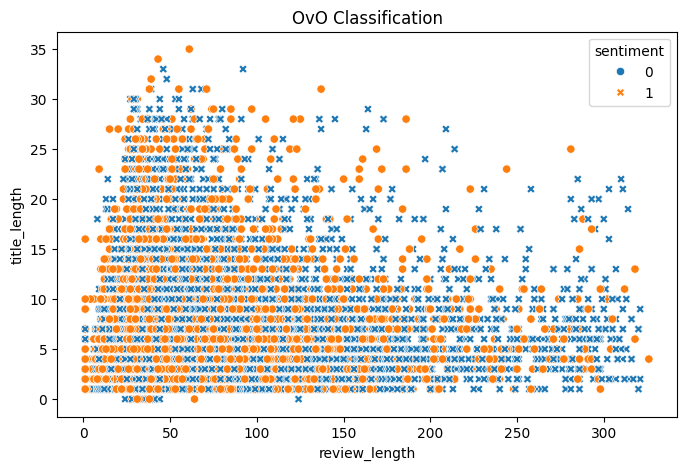

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsOneClassifier

# Assuming 'reviews' DataFrame is already loaded with the necessary columns ('review', 'rating', 'year')

# Preprocess the data (assuming 'reviews' is loaded)
reviews['sentiment'] = reviews['rating'].apply(lambda x: 1 if x > 3 else 0)

# Calculate review length and add it to 'reviews' (number of words)
reviews['review_length'] = reviews['review'].str.split().apply(len)

# Replace NaN values in 'title' with an empty string
reviews['title'] = reviews['title'].fillna('')

# Calculate title length and add it to 'reviews' (number of words)
reviews['title_length'] = reviews['title'].str.split().apply(len)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews[['review', 'review_length', 'title_length']], reviews['sentiment'], test_size=0.2, random_state=42)

# Define and train OvO and OvR classifiers
reviews_ovo = OneVsOneClassifier(LinearRegression()).fit(X_train_vec, y_train)

# Visualize OvO Classification
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_test["review_length"], y=X_test["title_length"], hue=y_test, style=reviews_ovo.predict(X_test_vec) == y_test)
plt.title('OvO Classification')
plt.show()

### Feature Engineering

In [84]:
min_wage=pd.read_csv('Minimum Wage Data.csv', encoding='latin1')

In [85]:
def state_column(location):
    for state in states:
        if state[0].lower() in location.lower():
            return state[1]
    return 'none'
min_wage_filtered=pd.DataFrame()
min_wage_filtered['Year']=min_wage['Year']
min_wage_filtered['State']=min_wage['State']
min_wage_filtered['State.Minimum.Wage']=min_wage['State.Minimum.Wage']
min_wage_filtered['STATE ABB']=min_wage_filtered['State'].apply(state_column)
min_wage_filtered['Time_and_Place'] = min_wage_filtered['STATE ABB'] + '_' + min_wage_filtered['Year'].astype(str)
min_wage_filtered

,Year,State,State.Minimum.Wage,STATE ABB,Time_and_Place
0,1968,Alabama,0.00000,AL,AL_1968
1,1968,Alaska,2.10000,AK,AK_1968
2,1968,Arizona,0.46800,AZ,AZ_1968
3,1968,Arkansas,0.15625,AR,AR_1968
4,1968,California,1.65000,CA,CA_1968
...,...,...,...,...,...
2857,2020,Virginia,7.25000,VA,VA_2020
2858,2020,Washington,13.50000,WA,WA_2020
2859,2020,West Virginia,8.75000,VA,VA_2020
2860,2020,Wisconsin,7.25000,WI,WI_2020


In [86]:
#Add 'Time_Place' column to reviews
reviews['Time_Place'] = reviews['state'] + '_' + reviews['year'].astype(str)
# Merge based on different columns with the same values
reviews = pd.merge(reviews, min_wage_filtered, left_on='Time_Place', right_on='Time_and_Place', how='inner')
reviews=reviews.drop(columns=['Time_Place','Time_and_Place','Year','State'],axis=1)
reviews


,title,review,rating,status,position,year,month,day,covid category,state,sentiment,review_length,title_length,State.Minimum.Wage,STATE ABB
0,great place to work,Indeed Featured reviewThe most useful review s...,4,Former Employee,"CUSTOMER SERVICE SUPERVISOR, OVER-NIGHT",2018,3,23,pre-covid era,PA,1,9,4,7.25,PA
1,nice easy going place to work most of the time,during most of my time working here we mostly ...,4,Former Employee,Modular Team Associate,2020,12,31,covid era,TX,1,46,10,7.25,TX
2,Treated as if you are not human,"They will mistreat, put you down, and talk to ...",1,Current Employee,Stocker,2020,12,31,covid era,AL,0,59,7,0.00,AL
3,Productive and supportive workplace,Great role where you can deal with the general...,4,Current Employee,Cashier,2020,12,31,covid era,NE,1,30,4,9.00,NE
4,Good as a starting job.,Provides good life and job learning experience...,4,Former Employee,Inventory Management Associate,2020,12,31,covid era,MI,1,26,5,9.65,MI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184080,"Fast Pace,employes parties,great benifits",A fast and fun place to work at.May be able to...,3,Former Employee,Customer Service,2011,4,6,pre-covid era,MO,0,15,4,7.25,MO
184081,Productive business,I loved working for walmart because of the fri...,5,Former Employee,SALES ASSOCIATE,2011,4,1,pre-covid era,AR,1,15,2,6.25,AR
184082,Good place to work overall.,Walmart is a good place to work though in the ...,4,Former Employee,"Department Manager, Frozen Associate",2011,3,14,pre-covid era,TN,1,70,5,0.00,TN
184083,Not as bad as most think.,I enjoyed working for Wal-Mart for the most pa...,4,Former Employee,Department Manager,2011,3,8,pre-covid era,IL,1,17,6,8.25,IL
